<a href="https://colab.research.google.com/github/Lutris98/21_1Q/blob/master/4.House/House_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.EDA

In [581]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error

In [582]:
from google.colab import drive
drive.mount('/content/gdrive')
train_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/house_train.csv')
test_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/house_test.csv')
id=test_df['Id'] #only for submission 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [583]:
df=pd.concat([train_df,test_df],axis=0,ignore_index=True)

##1) Basic statistics

In [584]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [585]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

##2) Basic feature selection


In [586]:
df.drop(['Alley','PoolQC','Fence','MiscFeature','FireplaceQu','Id'],axis=1,inplace=True) #features with too little data(logical thinking) #Surprisingly all data were meaningful by own meaning

#2.Preprocessing

In [587]:
discrete=[var for var in df.columns if df[var].dtype!='object' and var!='SalePrice' and df[var].nunique()<10] 
continuous=[var for var in df.columns if df[var].dtype!='object' and var!='SalePrice' and var not in discrete]
categorical=[var for var in df.columns if df[var].dtype=='object'] 
print(f'discrete:{discrete}\ncontinuous:{continuous}\ncategorical:{categorical}')

discrete:['OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'YrSold']
continuous:['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold']
categorical:['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', '

##1) Imputation

In [588]:
df.isnull().sum().sort_values(ascending=False).head(35)

SalePrice       1459
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtFullBath       2
BsmtHalfBath       2
BsmtFinSF1         1
BsmtFinSF2         1
Exterior2nd        1
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
Electrical         1
Exterior1st        1
KitchenQual        1
SaleType           1
GarageCars         1
LotShape           0
Street             0
LotArea            0
LandContour        0
Neighborhood       0
dtype: int64

In [589]:
imputer=SimpleImputer(strategy='most_frequent')
nd=imputer.fit_transform(df.drop('SalePrice',axis=1)) #only 5% so ignoring at baseline
fdf=pd.DataFrame(nd,columns=df.drop('SalePrice',axis=1).columns)
df=pd.concat([df['SalePrice'],fdf],axis=1)
df.isnull().sum().sort_values(ascending=False).head(10) #insight1.Concentrated in Lot/Garage #insight2.first two are continuous(easy) rest are categorical(needs encoding first)

SalePrice      1459
YearBuilt         0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        0
MasVnrArea        0
ExterQual         0
ExterCond         0
dtype: int64

##2) Encoding
Further imputation needs encoding

In [590]:
ordinal=['Street','LotShape','LandContour','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageFinish','GarageQual','GarageCond','PavedDrive']
nominal=[var for var in categorical if var not in ordinal] #sorted by reading explanation
print(nominal)

['MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'GarageType', 'SaleType', 'SaleCondition']


In [591]:
for var in categorical:
  print(var,':',df[var].nunique())

MSZoning : 5
Street : 2
LotShape : 4
LandContour : 4
Utilities : 2
LotConfig : 5
LandSlope : 3
Neighborhood : 25
Condition1 : 9
Condition2 : 8
BldgType : 5
HouseStyle : 8
RoofStyle : 6
RoofMatl : 8
Exterior1st : 15
Exterior2nd : 16
MasVnrType : 4
ExterQual : 4
ExterCond : 5
Foundation : 6
BsmtQual : 4
BsmtCond : 4
BsmtExposure : 4
BsmtFinType1 : 6
BsmtFinType2 : 6
Heating : 6
HeatingQC : 5
CentralAir : 2
Electrical : 5
KitchenQual : 4
Functional : 7
GarageType : 6
GarageFinish : 3
GarageQual : 5
GarageCond : 5
PavedDrive : 3
SaleType : 9
SaleCondition : 6


In [592]:
for var in ordinal:
  print(var,df[var].unique())

Street ['Pave' 'Grvl']
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities ['AllPub' 'NoSeWa']
LandSlope ['Gtl' 'Mod' 'Sev']
ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual ['Gd' 'TA' 'Ex' 'Fa']
BsmtCond ['TA' 'Gd' 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' 'ALQ' 'Rec' 'LwQ' 'GLQ']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
CentralAir ['Y' 'N']
Electrical ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
Functional ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
GarageFinish ['RFn' 'Unf' 'Fin']
GarageQual ['TA' 'Fa' 'Gd' 'Ex' 'Po']
GarageCond ['TA' 'Fa' 'Gd' 'Po' 'Ex']
PavedDrive ['Y' 'N' 'P']


In [593]:
df['Street']=df['Street'].replace({'Pave':0,'Grvl':1}) #LabelEncoder is useless
df['LotShape']=df['LotShape'].replace({'Reg':0,'IR1':1,'IR2':2,'IR3':3}) 
df['LandContour']=df['LandContour'].replace({'Lvl':0,'Bnk':1,'HLS':2,'Low':3})
df['Utilities']=df['Utilities'].replace({'AllPub':0,'NoSeWa':1}) 
df['LandSlope']=df['LandSlope'].replace({'Gtl':0,'Mod':1,'Sev':2})
df['ExterQual']=df['ExterQual'].replace({'Ex':0,'Gd':1,'Fa':2,'TA':3})
df['ExterCond']=df['ExterCond'].replace({'Ex':0,'Gd':1,'Fa':2,'TA':3,'Po':4})
df['BsmtQual']=df['BsmtQual'].replace({'Ex':0,'Gd':1,'Fa':2,'TA':3})
df['BsmtCond']=df['BsmtCond'].replace({'Gd':0,'Fa':1,'TA':2,'Po':3})
df['BsmtExposure']=df['BsmtExposure'].replace({'Gd':0,'Av':1,'Mn':2,'No':3})
df['BsmtFinType1']=df['BsmtFinType1'].replace({'GLQ':0,'ALQ':1,'BLQ':2,'Rec':3,'LwQ':4,'Unf':5})
df['BsmtFinType2']=df['BsmtFinType2'].replace({'GLQ':0,'ALQ':1,'BLQ':2,'Rec':3,'LwQ':4,'Unf':5})
df['HeatingQC']=df['HeatingQC'].replace({'Ex':0,'Gd':1,'Fa':2,'TA':3,'Po':4})
df['CentralAir']=df['CentralAir'].replace({'Y':0,'N':1})
df['Electrical']=df['Electrical'].replace({'SBrkr':0,'FuseA':1,'FuseF':2,'FuseP':3,'Mix':4})
df['KitchenQual']=df['KitchenQual'].replace({'Ex':0,'Gd':1,'Fa':2,'TA':3})
df['Functional']=df['Functional'].replace({'Typ':0,'Min1':1,'Min2':2,'Mod':3,'Maj1':4,'Maj2':5,'Sev':6})
df['GarageFinish']=df['GarageFinish'].replace({'Fin':0,'RFn':1,'Unf':2})
df['GarageQual']=df['GarageQual'].replace({'Ex':0,'Gd':1,'Fa':2,'TA':3,'Po':4})
df['GarageCond']=df['GarageCond'].replace({'Ex':0,'Gd':1,'Fa':2,'TA':3,'Po':4})
df['PavedDrive']=df['PavedDrive'].replace({'Y':0,'P':1,'N':2})

In [594]:
df=pd.get_dummies(df,columns=nominal)  #still room for improvement

In [595]:
df.head()

,SalePrice,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,...,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,208500.0,60,65,8450,0,0,0,0,0,7,5,2003,2003,196,1,3,1,2,3,0,706,5,0,150,856,0,0,0,856,854,0,1710,1,0,2,1,3,1,1,8,...,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,181500.0,20,80,9600,0,0,0,0,0,6,8,1976,1976,0,3,3,1,2,0,1,978,5,0,284,1262,0,0,0,1262,0,0,1262,0,1,2,0,3,1,3,6,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,223500.0,60,68,11250,0,1,0,0,0,7,5,2001,2002,162,1,3,1,2,2,0,486,5,0,434,920,0,0,0,920,866,0,1786,1,0,2,1,3,1,1,6,...,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,140000.0,70,60,9550,0,1,0,0,0,7,5,1915,1970,0,3,3,3,0,3,1,216,5,0,540,756,1,0,0,961,756,0,1717,1,0,1,0,3,1,1,7,...,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,250000.0,60,84,14260,0,1,0,0,0,8,5,2000,2000,350,1,3,1,2,1,0,655,5,0,490,1145,0,0,0,1145,1053,0,2198,1,0,2,1,4,1,1,9,...,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


##3) Discretization&Scaling

In [596]:
for var in continuous: #ignore at regression
  print(var,':',df[var].nunique())

MSSubClass : 16
LotFrontage : 128
LotArea : 1951
OverallQual : 10
YearBuilt : 118
YearRemodAdd : 61
MasVnrArea : 444
BsmtFinSF1 : 991
BsmtFinSF2 : 272
BsmtUnfSF : 1135
TotalBsmtSF : 1058
1stFlrSF : 1083
2ndFlrSF : 635
LowQualFinSF : 36
GrLivArea : 1292
TotRmsAbvGrd : 14
GarageYrBlt : 103
GarageArea : 603
WoodDeckSF : 379
OpenPorchSF : 252
EnclosedPorch : 183
3SsnPorch : 31
ScreenPorch : 121
PoolArea : 14
MiscVal : 38
MoSold : 12


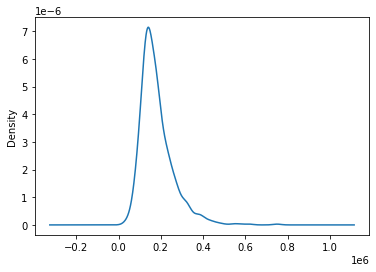

In [597]:
train_df.SalePrice.plot.kde()

##4) feature selection

#3.Modeling

In [598]:
test_df=df[df['SalePrice'].isna()!=0]
train_df=df[df['SalePrice'].isna()==0]
target_df=train_df['SalePrice']
feature_df=train_df.drop(['SalePrice'],axis=1,inplace=False)
X_train,X_test,y_train,y_test=train_test_split(feature_df,target_df,test_size=0.2,random_state=42)

In [599]:
def get_eval(real,pred):
  eval=np.sqrt(mean_squared_error(np.log1p(real),np.log1p(pred))) #mse is embedded metric #only targetdata is logscaled 
  print('RMSLE:',eval)

In [600]:
lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred1=lr_reg.predict(X_test)
ridge_reg=Ridge()
ridge_reg.fit(X_train,y_train)
pred2=ridge_reg.predict(X_test)
lasso_reg=Lasso()
lasso_reg.fit(X_train,y_train)
pred3=lasso_reg.predict(X_test)
vo_reg=VotingRegressor(estimators=[('simple',lr_reg),('ridge',ridge_reg),('lasso',lasso_reg)])
vo_reg.fit(X_train,y_train)
pred4=vo_reg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211774679546.39978, tolerance: 696659484.3571944
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211774679546.39978, tolerance: 696659484.3571944
  positive)


In [601]:
get_eval(y_test,pred1)
get_eval(y_test,pred2)
get_eval(y_test,pred3)
get_eval(y_test,pred4)

RMSLE: 0.1929769141114557
RMSLE: 0.15938335552937855
RMSLE: 0.18565516710759802
RMSLE: 0.17143067240619983


#Uploading

In [602]:
test_df.drop('SalePrice',axis=1,inplace=True)
realpred=vo_reg.predict(test_df)
realpred=pd.DataFrame(realpred, columns=['SalePrice']) 
submit_df=pd.DataFrame({'Id':id,'SalePrice':realpred['SalePrice']}) 
submit_df.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Id,SalePrice
0,1461,118323.592755
1,1462,154641.889548
2,1463,177378.014263


In [603]:
submit_df.to_csv('/content/gdrive/MyDrive/Dataset/House.csv', index = False)

#1) Feedback

#2) Afterwords
